## Logistic Regression

Load Data

In [1]:
import numpy as np
import pandas as pd

X_full = pd.read_csv('./Datasets/train.csv', index_col='PassengerId')

y = X_full.Survived
X = X_full.copy()
X.dropna(axis=0, subset=['Survived'], inplace=True)
X.drop(['Survived'], axis=1, inplace=True)

Check if any null

In [2]:
X.isnull().sum()

Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

For embarked impute with a new feature value of Missing.
For Age impute with most frequent.
For Cabin, due to large number of missing values, dropping.

In [3]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
X['Age'] = imputer.fit_transform(X[['Age']])
X['Embarked'] = X['Embarked'].fillna('Missing')
X.drop(['Cabin'], axis=1, inplace=True)

Encode Categorical Columns

In [4]:
categorical_cols = [cname for cname in X.columns if
                    X[cname].dtype == "object"]
X[categorical_cols].nunique()

Name        891
Sex           2
Ticket      681
Embarked      4
dtype: int64

Use label encoder for name and ticket due large number of unique values.
Use OneHotEncoder for Sex and Embarked.

In [5]:
# Encode categorical columns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

low_card_cols = ["Sex", "Embarked"]
high_card_cols = ["Name", "Ticket"]

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_encoded =  encoder.fit_transform(X[low_card_cols])
column_names = encoder.get_feature_names(low_card_cols)
X_encoded = pd.DataFrame(X_encoded, columns = column_names)
X_encoded.index = X[low_card_cols].index

X.drop(low_card_cols, axis=1, inplace=True)
X = pd.concat([X, X_encoded], axis=1)

label_encoder = LabelEncoder()
for col in high_card_cols:
    X[col] = label_encoder.fit_transform(X[col])
    
X.head()

,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Missing,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,
1,3,108,22.0,1,0,523,7.2500,0.0,1.0,0.0,0.0,0.0,1.0
2,1,190,38.0,1,0,596,71.2833,1.0,0.0,1.0,0.0,0.0,0.0
3,3,353,26.0,0,0,669,7.9250,1.0,0.0,0.0,0.0,0.0,1.0
4,1,272,35.0,1,0,49,53.1000,1.0,0.0,0.0,0.0,0.0,1.0
5,3,15,35.0,0,0,472,8.0500,0.0,1.0,0.0,0.0,0.0,1.0


Scale the data for regression 

In [6]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))
X_scaled.columns= X.columns
X_scaled.index = X.index
X = X_scaled
X.head()

,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Missing,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,
1,0.827377,-1.310217,-0.497793,0.432793,-0.473674,0.918966,-0.502445,-0.737695,0.737695,-0.482043,-0.047431,-0.307562,0.619306
2,-1.566107,-0.991410,0.715048,0.432793,-0.473674,1.282625,0.786845,1.355574,-1.355574,2.074505,-0.047431,-0.307562,-1.614710
3,0.827377,-0.357685,-0.194583,-0.474545,-0.473674,1.646283,-0.488854,1.355574,-1.355574,-0.482043,-0.047431,-0.307562,0.619306
4,-1.566107,-0.672604,0.487640,0.432793,-0.473674,-1.442322,0.420730,1.355574,-1.355574,-0.482043,-0.047431,-0.307562,0.619306
5,0.827377,-1.671790,0.487640,-0.474545,-0.473674,0.664904,-0.486337,-0.737695,0.737695,-0.482043,-0.047431,-0.307562,0.619306


### Logistic Regression + RFE

Test Logistic Regression with RFE for feature selection. Chose random of 10 features for analysis

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

model = LogisticRegression(max_iter = 5000)
rfe = RFE(model, 10) # Select all
rfe = rfe.fit(X, y)

print("Selected columns", X.columns[rfe.support_])
print("Columns ranking", rfe.ranking_)

Selected columns Index(['Pclass', 'Name', 'Age', 'SibSp', 'Ticket', 'Fare', 'Sex_female',
       'Sex_male', 'Embarked_Missing', 'Embarked_S'],
      dtype='object')
Columns ranking [1 1 1 1 2 1 1 1 1 3 1 4 1]


### Best Feature selection using Cross Validation with Logistic Regression

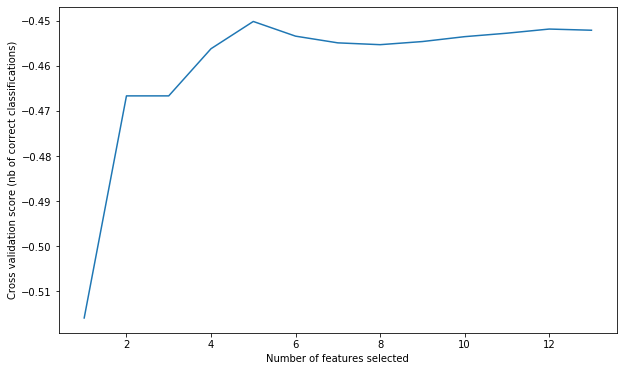

Optimal number of features: 5
Selected features: ['Pclass', 'Age', 'SibSp', 'Sex_female', 'Sex_male']
Rankings of the features: [1 6 1 1 7 4 5 1 1 8 3 9 2]


In [8]:
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt 

rfecv = RFECV(estimator=LogisticRegression(max_iter=1000), step=1, cv=10, scoring='neg_log_loss')
rfecv.fit(X, y)

plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected features: {list(X.columns[rfecv.support_])}")
print(f"Rankings of the features: {rfecv.ranking_}")

### ROC Curve for different thresholds for the best selected feature from above

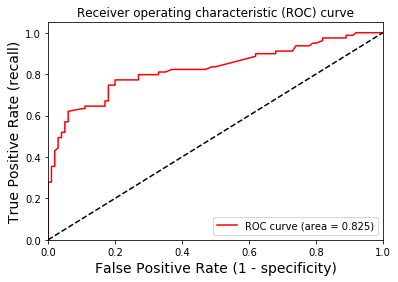

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

best_features = X.columns[rfecv.support_].tolist()
X_best = X[best_features]

X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size=0.2, random_state=2)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

Metrics for different scoring functions

In [10]:
from sklearn.model_selection import cross_validate

scoring = ['accuracy', 'neg_log_loss', 'roc_auc']

results = cross_validate(LogisticRegression(max_iter=1000), X, y, cv=10, 
                         scoring=scoring, return_train_score=False)

for sc in scoring:
    print(f"Score for function {sc} is {results[f'test_{sc}'].mean()}")

Score for function accuracy is 0.7957553058676654
Score for function neg_log_loss is -0.4521253534714756
Score for function roc_auc is 0.8541560139207197
